# Compute annual timeseries & epoch means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from itertools import product

import cartopy
import cartopy.crs as ccrs
import cmocean
import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import numpy as np
import operators as ops
import pop_tools
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# if False:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='25GB')
    cluster.scale(200)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.40:43588,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)

catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [6]:
def vol_weighted_mean(ds):
    vol_mask = ops.pop_ocean_volume(ds)
    return ds.weighted(vol_mask).mean(['z_t', 'nlat', 'nlon']).drop(['REGION_MASK'])


def vol_weighted_mean_blw200m(ds):
    vol_mask = ops.pop_ocean_volume(ds)
    vol_mask = vol_mask.where(vol_mask.z_t > 200e2).fillna(0.0)
    return ds.weighted(vol_mask).mean(['z_t', 'nlat', 'nlon']).drop(['REGION_MASK'])


operations = {
    "ann": dict(
        func=ops.resample_ann,
        add_ops=["resample_ann"],
        dep_name="drift-corrected",
    ),
    "ann.ts-glb": dict(
        func=vol_weighted_mean,
        add_ops=["resample_ann", "vol-weighted-mean"],
        dep_name="drift-corrected.ann",
    ),
    "ann.ts-glb-blw200m": dict(
        func=vol_weighted_mean_blw200m,
        add_ops=["resample_ann", "vol-weighted-mean-blw200m"],
        dep_name="drift-corrected.ann",
    ),
}
ops_ordered = ['ann'] + [k for k in operations.keys() if k != 'ann']
ops_ordered

['ann', 'ann.ts-glb', 'ann.ts-glb-blw200m']

In [7]:
clobber = False
stream = 'pop.h'
component = 'ocn'

variable_list = ['TEMP', 'pO2']

for operation in ops_ordered:
    info = operations[operation]

    dep_name = info['dep_name']
    add_ops = info['add_ops']
    func = info['func']

    catalog = funnel.to_intake_esm(agg_member_id=False)

    for experiment, member_id, variable in product(experiment_list, member_id_list, variable_list):
        # check for existing cache file
        asset = dc.fnl_gen_cache_file_name(
            experiment, component, stream, member_id, variable, f'drift-corrected.{operation}'
        )

        if clobber and os.path.exists(asset):
            print(f'removing: {asset}')
            shutil.rmtree(asset)

        if os.path.exists(asset):
            # print(f'exists: {asset}')
            continue

        with util.timer(f'{operation}.{member_id}.{variable}'):
            cat = catalog.search(
                name=dep_name,
                experiment=experiment,
                member_id=member_id,
                stream=stream,
                component=component,
                variable=variable,
            )

            dset = cat.to_dataset_dict()
            assert len(dset.keys()) == 1
            _, ds = dset.popitem()
            ds['REGION_MASK'] = pop_tools.get_grid('POP_gx1v6')['REGION_MASK']

            dso = func(ds)

            print(f'writing: {asset}')
            dso.to_zarr(asset, mode="w", consolidated=True)
            dc.fnl_make_cache(
                experiment,
                component,
                stream,
                member_id,
                variable,
                f"drift-corrected.{operation}",
                add_ops,
            )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.2.TEMP]: 11.74069s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.2.pO2]: 2.48845s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.9.TEMP]: 2.84916s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.9.pO2]: 3.44611s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.10.TEMP]: 2.93129s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.10.pO2]: 2.51964s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.11.TEMP]: 2.49748s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.11.pO2]: 2.56390s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.12.TEMP]: 2.56095s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.12.pO2]: 2.46124s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.13.TEMP]: 2.64017s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.13.pO2]: 2.49939s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.14.TEMP]: 2.45776s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.14.pO2]: 2.90690s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.15.TEMP]: 2.39245s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.15.pO2]: 2.47227s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.16.TEMP]: 2.39260s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.16.pO2]: 2.92267s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.17.TEMP]: 2.70500s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.17.pO2]: 2.45699s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.18.TEMP]: 2.53453s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.18.pO2]: 2.57449s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.19.TEMP]: 2.69733s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.19.pO2]: 2.49551s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.020.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.20.TEMP]: 2.45664s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.020.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.20.pO2]: 2.71921s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.021.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.21.TEMP]: 2.72258s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.021.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.21.pO2]: 2.45808s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.022.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.22.TEMP]: 2.66739s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.022.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.22.pO2]: 2.70786s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.023.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.23.TEMP]: 2.45065s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.023.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.23.pO2]: 2.74990s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.024.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.24.TEMP]: 2.43572s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.024.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.24.pO2]: 2.55784s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.025.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.25.TEMP]: 2.43755s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.025.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.25.pO2]: 3.73513s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.026.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.26.TEMP]: 2.67497s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.026.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.26.pO2]: 2.57139s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.027.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.27.TEMP]: 2.48133s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.027.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.27.pO2]: 2.68502s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.028.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.28.TEMP]: 2.53728s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.028.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.28.pO2]: 2.66687s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.029.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.29.TEMP]: 2.48551s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.029.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.29.pO2]: 2.63047s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.30.TEMP]: 2.50939s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.30.pO2]: 2.55187s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.031.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.31.TEMP]: 2.53294s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.031.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.31.pO2]: 2.77594s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.032.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.32.TEMP]: 4.96761s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.032.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.32.pO2]: 2.53953s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.034.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.34.TEMP]: 2.62611s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.034.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.34.pO2]: 2.57950s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.035.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.35.TEMP]: 2.79511s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.035.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.35.pO2]: 2.47809s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.101.TEMP]: 2.55276s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.101.pO2]: 2.77996s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.102.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.102.TEMP]: 2.79691s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.102.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.102.pO2]: 2.53835s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.103.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.103.TEMP]: 2.60807s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.103.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.103.pO2]: 2.78051s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.104.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.104.TEMP]: 2.45647s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.104.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.104.pO2]: 2.51349s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.105.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.105.TEMP]: 2.85159s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.105.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.105.pO2]: 2.78583s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.002.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.2.TEMP]: 2.75335s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.002.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.2.pO2]: 2.84777s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.009.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.9.TEMP]: 2.90538s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.009.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.9.pO2]: 3.07667s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.010.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.10.TEMP]: 2.85511s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.010.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.10.pO2]: 3.32576s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.011.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.11.TEMP]: 2.74162s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.011.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.11.pO2]: 2.84500s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.012.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.12.TEMP]: 2.87756s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.012.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.12.pO2]: 2.86346s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.013.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.13.TEMP]: 3.61708s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.013.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.13.pO2]: 2.88134s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.014.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.14.TEMP]: 3.06257s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.014.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.14.pO2]: 2.71105s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.015.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.15.TEMP]: 3.13522s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.015.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.15.pO2]: 2.86297s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.016.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.16.TEMP]: 2.89080s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.016.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.16.pO2]: 3.00895s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.017.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.17.TEMP]: 3.14794s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.017.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.17.pO2]: 2.84508s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.018.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.18.TEMP]: 2.89215s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.018.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.18.pO2]: 2.84739s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.019.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.19.TEMP]: 3.22731s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.019.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.19.pO2]: 2.86554s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.020.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.20.TEMP]: 2.83607s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.020.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.20.pO2]: 3.10951s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.021.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.21.TEMP]: 2.47449s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.021.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.21.pO2]: 3.54131s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.022.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.22.TEMP]: 2.96602s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.022.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.22.pO2]: 2.94659s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.023.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.23.TEMP]: 3.06401s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.023.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.23.pO2]: 2.89735s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.024.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.24.TEMP]: 2.80853s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.024.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.24.pO2]: 3.21234s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.025.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.25.TEMP]: 2.81327s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.025.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.25.pO2]: 2.80997s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.026.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.26.TEMP]: 2.71009s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.026.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.26.pO2]: 3.28346s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.027.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.27.TEMP]: 2.91397s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.027.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.27.pO2]: 2.80026s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.028.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.28.TEMP]: 2.98341s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.028.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.28.pO2]: 3.10664s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.029.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.29.TEMP]: 2.84139s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.029.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.29.pO2]: 2.87977s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.030.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.30.TEMP]: 2.91408s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.030.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.30.pO2]: 2.91508s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.031.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.31.TEMP]: 2.84377s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.031.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.31.pO2]: 2.93482s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.032.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.32.TEMP]: 2.93286s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.032.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.32.pO2]: 2.84810s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.034.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.34.TEMP]: 2.85109s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.034.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.34.pO2]: 2.96273s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.035.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.35.TEMP]: 2.99096s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.035.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.35.pO2]: 2.88953s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.101.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.101.TEMP]: 2.91885s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.101.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.101.pO2]: 2.91999s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.102.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.102.TEMP]: 2.96841s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.102.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.102.pO2]: 4.38660s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.103.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.103.TEMP]: 2.83427s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.103.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.103.pO2]: 2.85952s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.104.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.104.TEMP]: 2.83030s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.104.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.104.pO2]: 2.88670s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.105.TEMP.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.105.TEMP]: 2.87917s

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.105.pO2.drift-corrected.ann.ts-glb-blw200m.zarr
[ann.ts-glb-blw200m.105.pO2]: 2.81161s


In [8]:
del client
del cluster

In [9]:
sub_spec = dict(
    name='drift-corrected.ann.ts-glb-blw200m',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)

cat = catalog.search(variable=variable_list)
dsets = cat.to_dataset_dict()

exp_keys = [
    '20C.ocn.pop.h.drift-corrected.ann.ts-glb-blw200m',
    'RCP85.ocn.pop.h.drift-corrected.ann.ts-glb-blw200m',
]

ds = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal', compat='override')
ds = ds.compute()
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:    (member_id: 32, time: 181)
Coordinates:
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
Data variables:
    TEMP       (member_id, time) float64 6.943 6.944 6.944 ... 8.125 8.147 8.171
    pO2        (member_id, time) float64 10.16 10.16 10.14 ... 9.528 9.516 9.518
Attributes:
    intake_esm_varname:      TEMP\npO2
    intake_esm_dataset_key:  20C.ocn.pop.h.drift-corrected.ann.ts-glb-blw200m

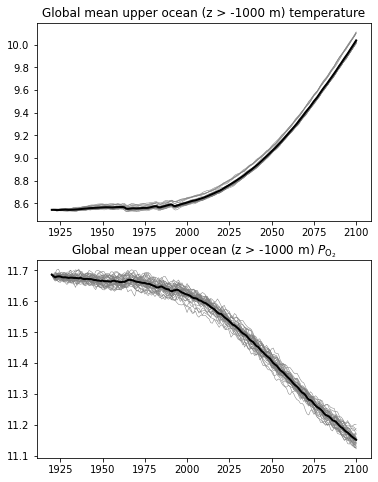

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), squeeze=False)

ax = axs[0, 0]
for member_id in ds.member_id.values:
    ax.plot(
        ds.time,
        ds.TEMP.sel(member_id=member_id),
        linestyle='-',
        color='gray',
        linewidth=0.5,
    )

ax.plot(ds.time, ds.TEMP.mean('member_id'), '-', color='k', linewidth=2)
ax.set_title('Global mean upper ocean (z > -1000 m) temperature')

ax = axs[1, 0]
for member_id in ds.member_id.values:
    ax.plot(
        ds.time,
        ds.pO2.sel(member_id=member_id),
        linestyle='-',
        color='gray',
        linewidth=0.5,
    )

ax.plot(ds.time, ds.pO2.mean('member_id'), '-', color='k', linewidth=2)
ax.set_title(r'Global mean upper ocean (z > -1000 m) $P_{\mathrm{O}_2}$');

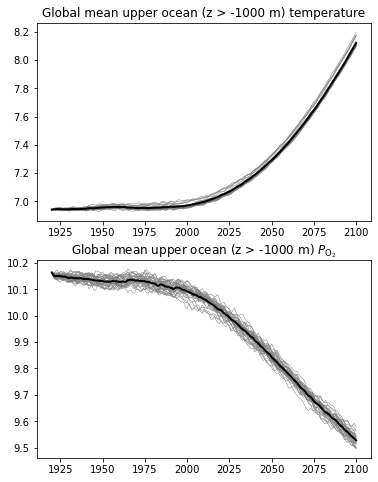

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), squeeze=False)

ax = axs[0, 0]
for member_id in ds.member_id.values:
    ax.plot(
        ds.time,
        ds.TEMP.sel(member_id=member_id),
        linestyle='-',
        color='gray',
        linewidth=0.5,
    )

ax.plot(ds.time, ds.TEMP.mean('member_id'), '-', color='k', linewidth=2)
ax.set_title('Global mean upper ocean (z > -1000 m) temperature')

ax = axs[1, 0]
for member_id in ds.member_id.values:
    ax.plot(
        ds.time,
        ds.pO2.sel(member_id=member_id),
        linestyle='-',
        color='gray',
        linewidth=0.5,
    )

ax.plot(ds.time, ds.pO2.mean('member_id'), '-', color='k', linewidth=2)
ax.set_title(r'Global mean upper ocean (z > -1000 m) $P_{\mathrm{O}_2}$');

In [10]:
curator = util.curator_local_assets()

clobber = True

this_notebook = 'compute-ts-and-epoch-means.ipynb'

curator = util.curator_local_assets()
key = 'cesm-le-global-ts'
if clobber:
    cache_file = f'data/cache/{key}.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    ds.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f'CESM-LE global means (upper 1 km) computed by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

cat = curator.open_catalog()
ds_cache = cat[key].to_dask()
xr.testing.assert_identical(ds, ds_cache)

overwriting "cesm-le-global-ts" key in "sources"


In [11]:
sub_spec = dict(
    name='drift-corrected.ann',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)

cat = catalog.search(variable=variable_list)
dsets = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


In [12]:
epoch = xr.DataArray(['ref_climate', '2100_climate'], dims=('epoch'))
with xr.set_options(keep_attrs=True):
    ds = xr.concat(
        [
            dsets['20C.ocn.pop.h.drift-corrected.ann'].sel(time=slice(1920, 1965)).mean('time'),
            dsets['RCP85.ocn.pop.h.drift-corrected.ann'].sel(time=slice(2080, 2100)).mean('time'),
        ],
        dim=epoch,
        coords='minimal',
    )
ds['REGION_MASK'] = ds.REGION_MASK[0, :, :]
ds

,Array,Chunk
Bytes,2.34 GiB,9.38 MiB
Shape,"(2, 32, 40, 384, 320)","(1, 1, 10, 384, 320)"
Count,90432 Tasks,256 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,2.34 GiB,9.38 MiB
Shape,"(2, 32, 40, 384, 320)","(1, 1, 10, 384, 320)"
Count,90432 Tasks,256 Chunks
Type,float64,numpy.ndarray


In [16]:
vol_mask = ops.pop_ocean_volume(ds)

with xr.set_options(keep_attrs=True):
    ds_glb = ds.weighted(ds.dz).mean(['z_t']).compute()
    ds_glb = ds_glb.drop(['REGION_MASK'])
    for v in ds_glb.data_vars:
        ds_glb[v] = ds_glb[v].mean('member_id')
ds_glb

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, member_id: 32, epoch: 2)
Coordinates:
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    TLAT       (member_id, nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    TLONG      (member_id, nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
  * epoch      (epoch) <U12 'ref_climate' '2100_climate'
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP       (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pO2        (epoch, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum:                  2592000.0
    intake_esm_varname:        TEMP\npO2
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    nco_openmp_thread_number:  1
    ...                        ...
    nsteps_total:              750
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    cell_methods:              cell_methods = time: mean ==> the variable val...
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected.ann

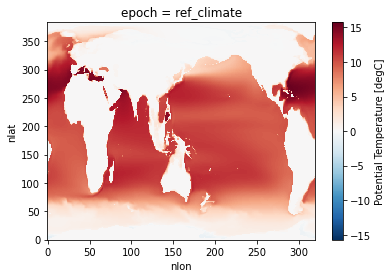

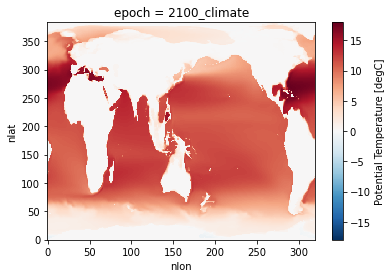

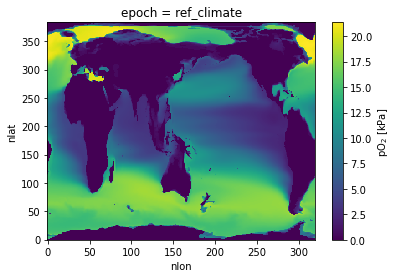

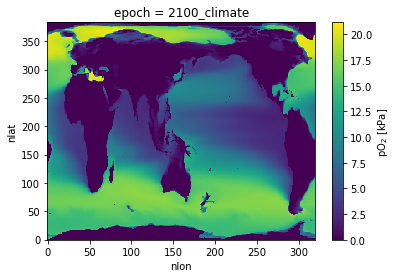

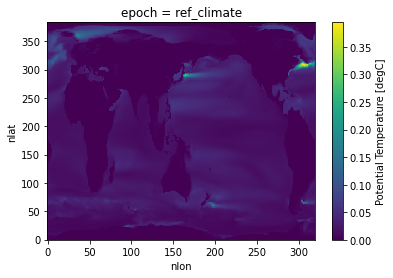

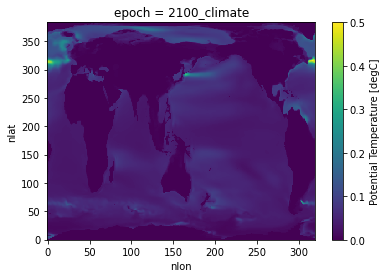

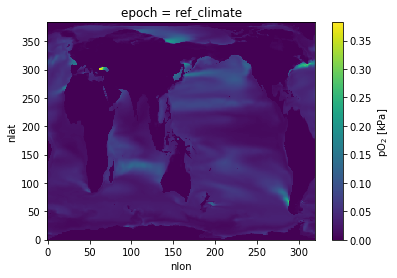

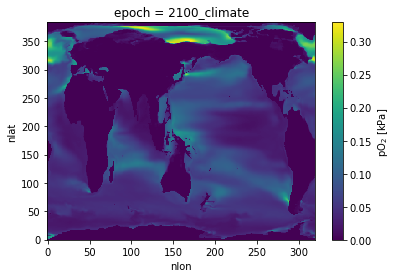

In [15]:
for v, e in product(ds_glb.data_vars, ds_glb.epoch.values):
    plt.figure()
    ds_glb[v].sel(epoch=e).plot();

In [17]:
curator = util.curator_local_assets()

clobber = True

this_notebook = 'compute-ts-and-epoch-means.ipynb'

curator = util.curator_local_assets()
key = 'cesm-le-epoch-means'
if clobber:
    cache_file = f'data/cache/{key}.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    ds_glb.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f'CESM-LE epoch means (upper 1 km) computed by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

cat = curator.open_catalog()
ds_cache = cat[key].to_dask()
xr.testing.assert_identical(ds_glb, ds_cache)

overwriting "cesm-le-global-epoch-means" key in "sources"
